## MUL Best Slice Selection Tool

Quick tool for manual selection of the best slices for each patient. The results are saved in a CSV file for comparison.

(**Important:** Please ensure the DICOM folder is saved with correct file names on, contains folders like "ProstateX-0000")

In [27]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line

import os
import glob
import csv

# Edit these paths so they are correct
root_path = "/Volumes/T5/2_Uni/FYP/data/sagittal_dicom"
savedtotal_path = os.path.join(root_path, "savedlouise_names")
savednumpy_path = os.path.join(root_path, "saved_numpy")
savedcsv_path = os.path.join(root_path, "savedlouise_best_slices.csv")

### Helper Functions

In [7]:
def get_mask_lines(gsps_ds):
    mask_lines = []
    graphic_annotation_sequence = gsps_ds.get((0x0070, 0x0001), [])
    for annotation in graphic_annotation_sequence:
        for graphic_object in annotation.get((0x0070, 0x0009), []):
            graphic_data = graphic_object.GraphicData
            if graphic_object.GraphicType == "POLYLINE":
                polyline = list(zip(graphic_data[::2], graphic_data[1::2]))
                x, y = zip(*polyline)
                mask_lines.append(polyline)
                # plt.plot(x, y, linestyle="-", linewidth=2, color="red")
    # plt.show()
    return mask_lines

def get_image_mask(image_array, mask_lines, mode="both"):
    mask = np.copy(image_array)
    if mode == "right":
        mask_lines = [mask_lines[0]]
    elif mode == "left":
        mask_lines = [mask_lines[1]]

    for m_line in mask_lines:
        m_line_points = list(reversed(m_line[0])) + list(reversed(m_line[1]))
        m_line_points = [int(x) for x in m_line_points]
        rr, cc = line(*m_line_points)
    
    return mask

In [29]:
def show_slices_with_annotation(image_dir, mask_lines, mode="both"):
    fig, axs = plt.subplots(5, 5, figsize=(15, 15))

    # Store slice images in correct order
    slice_images = {}
    num_slices = 0
    for file in os.listdir(image_dir):
        num_slices += 1
        image_file_path = os.path.join(image_dir, file)
        image_ds = pydicom.dcmread(image_file_path)
        slice_num = image_ds.InstanceNumber
        slice_images[slice_num] = image_ds.pixel_array

    # Show slice images with annotation
    for slice_num in range(1, num_slices+1):
        ax = axs[(slice_num - 1) // 5, (slice_num - 1) % 5]
        ax.imshow(slice_images[slice_num], cmap="gray")

        if mode == "right":
            mask_lines = [mask_lines[0]]
        elif mode == "left":
            mask_lines = [mask_lines[1]]
        for m_line in mask_lines:
            x, y = zip(*m_line)
            ax.plot(x, y, linestyle="-", linewidth=1, color="red")

        ax.set_title(f"Slice #{slice_num}")
        ax.axis("off")
    plt.show()

def show_image_mask(image_dir_path, mask_lines, mode="both"):
    file = os.listdir(image_dir_path)[0] # get first image just for dims
    image_file_path = os.path.join(image_dir_path, file)
    image_ds = pydicom.dcmread(image_file_path)

    mask = np.zeros_like(image_ds.pixel_array)

    plt.figure(figsize=(3, 3))
    plt.imshow(mask, cmap="gray")

    if mode == "right":
        mask_lines = [mask_lines[0]]
    elif mode == "left":
        mask_lines = [mask_lines[1]]
    for m_line in mask_lines:
        x, y = zip(*m_line)
        plt.plot(x, y, linestyle="-", linewidth=1, color="white")

    plt.title("Binary image mask")
    plt.axis("off")
    plt.show()

### Selection

For each set of patient images, a grid will be displayed with all of the slices overlayed with the radiologist's MUL annotations.

**Steps:**
1. Please input which slice number best aligns with the MUL annotations (Enter Esc to quit).
2. Once you have finished your selection, please run the next cells to save your output to a csv file.

(**Important:** Make sure you scroll the output so you are viewing the correct image grid for the patient you are selecting.)

Found annotation for patient: ProstateX-0204


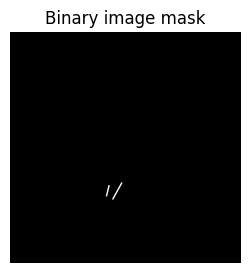

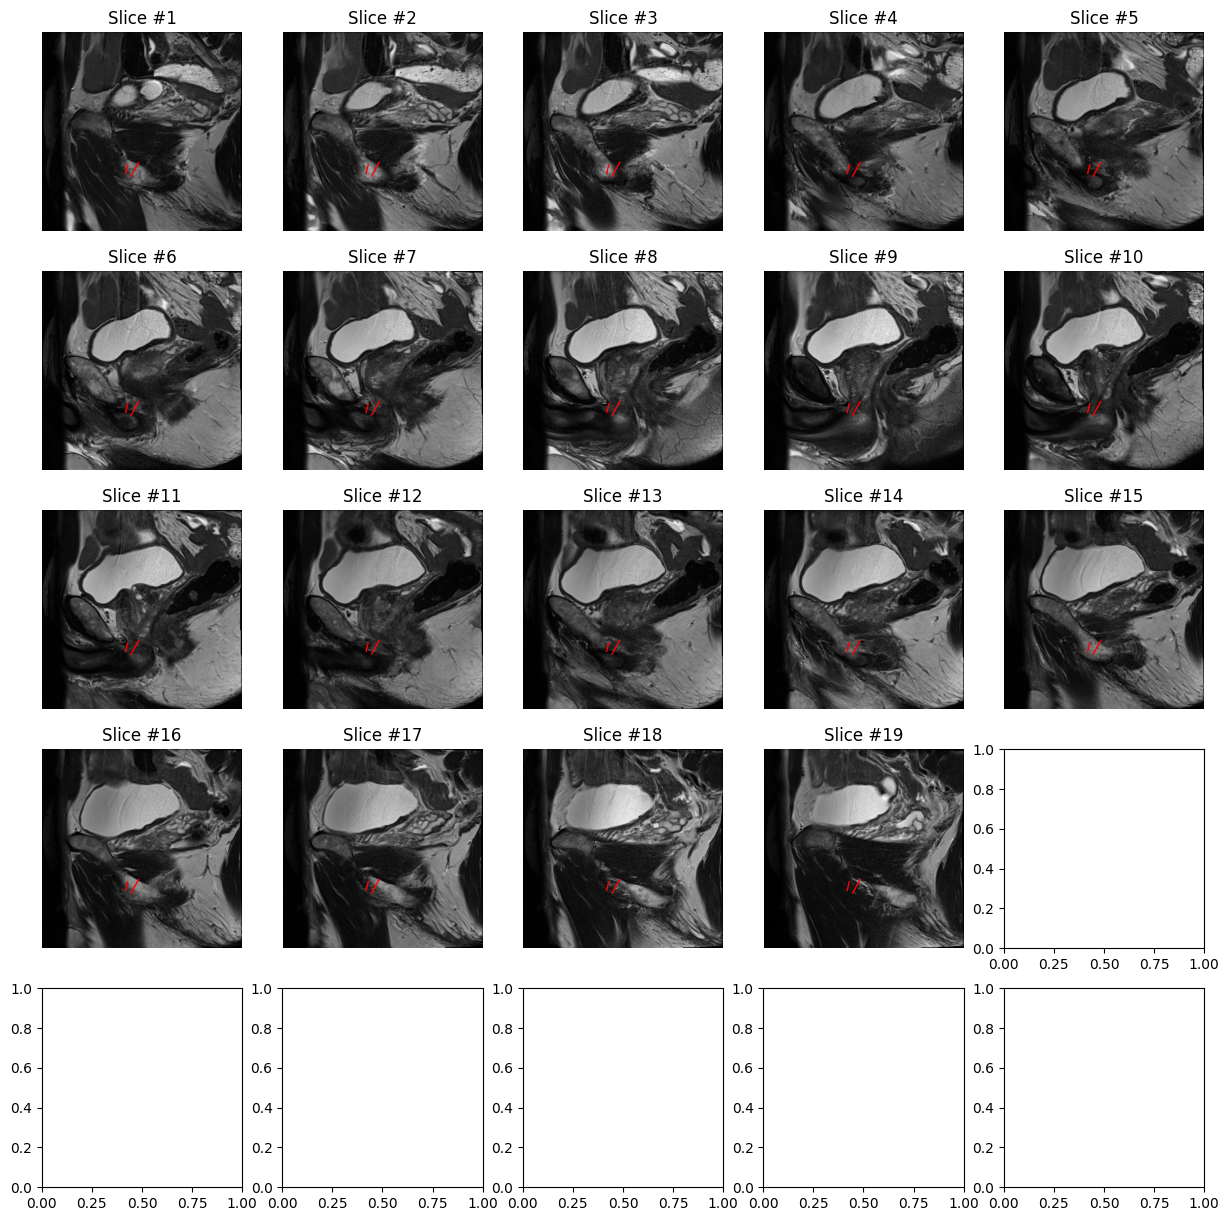

ValueError: invalid literal for int() with base 10: ''

In [30]:
best_slices = []

for patient_name in sorted(os.listdir(savedtotal_path)):
    patient_dir = os.path.join(savedtotal_path, patient_name)
    month_dir = os.listdir(patient_dir)[0]

    # Get image and annotation folders
    image_dir = glob.glob(os.path.join(patient_dir, month_dir, "*t2_tse_sag*"))[0] # find first tse sag folder
    gsps_dir = os.path.join(patient_dir, month_dir, "[999] PR Weasis GSPS -- 1 ins_") # always the same name

    # Check if annotation exists
    if os.path.isdir(gsps_dir):
        print(f"Found annotation for patient: {patient_name}")
        gsps_file = os.path.join(gsps_dir, os.listdir(gsps_dir)[0])

        gsps_ds = pydicom.dcmread(gsps_file)
        mask_lines = get_mask_lines(gsps_ds)
        show_image_mask(image_dir, mask_lines, mode="both")
        show_slices_with_annotation(image_dir, mask_lines, mode="both")

        # Get user input for best slice
        best_slice = int(input(f"Enter the best slice number for patient {patient_name}: "))
        best_slices.append([patient_name, best_slice])

        # TODO: Save mask and image for best slice

Output the best slices to check them and ensure there is something to be saved

In [24]:
best_slices

[['ProstateX-0204', 10],
 ['ProstateX-0205', 11],
 ['ProstateX-0206', 12],
 ['ProstateX-0207', 10],
 ['ProstateX-0208', 11],
 ['ProstateX-0209', 10],
 ['ProstateX-0210', 10],
 ['ProstateX-0211', 10],
 ['ProstateX-0212', 10],
 ['ProstateX-0213', 10],
 ['ProstateX-0214', 10]]

### Save Results

Save results to CSV file (path specified in first cell)

In [25]:
with open(savedcsv_path, "w", newline="") as f:
    writer = csv.writer(f)
    for row in best_slices:
        writer.writerow(row)